In [1]:
# https://www.kaggle.com/c/digit-recognizer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.decomposition import PCA
%matplotlib inline

from util import get_transformed_data, forward, error_rate, cost, gradW, gradb, y2indicator

In [3]:
# from util.py
def get_transformed_data():
    print("Reading in and transforming data...")
    df = pd.read_csv('./data/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)

    X = data[:, 1:]
    mu = X.mean(axis=0)
    X = X - mu # center the data
    pca = PCA()
    Z = pca.fit_transform(X)
    Y = data[:, 0]

    plot_cumulative_variance(pca)

    return Z, Y, pca, mu

In [4]:
def plot_cumulative_variance(pca):
    P = []
    for p in pca.explained_variance_ratio_:
        if len(P) == 0:
            P.append(p)
        else:
            P.append(p + P[-1])
    plt.plot(P)
    plt.show()
    return P

Reading in and transforming data...


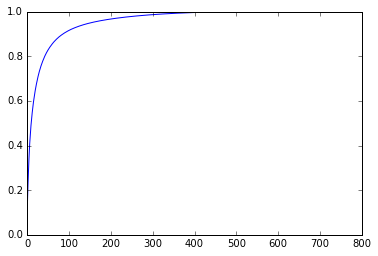

Performing logistic regression...


/Users/admin/Code/udemy_courses/udemy_lazyprogrammer_courses/4_practical_deep_learning_tensorflow/util.py:104: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ind[i, y[i]] = 1


In [5]:
X, Y, _, _ = get_transformed_data()
X = X[:, :300]

# normalize X first
mu = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mu) / std

print("Performing logistic regression...")
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest = X[-1000:,]
Ytest = Y[-1000:]

N, D = Xtrain.shape
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [6]:
# 1. full
W = np.random.randn(D, 10) / 28 # want weights to be small, proportional to the square of dims
b = np.zeros(10)
LL = []
lr = 0.0001
reg = 0.01
t0 = datetime.now()
for i in range(200):
    p_y = forward(Xtrain, W, b)
    
    W += lr*(gradW(Ytrain_ind, p_y, Xtrain) - reg*W)
    b += lr*(gradb(Ytrain_ind, p_y) - reg*b)
    
    p_y_test = forward(Xtest, W, b)
    ll = cost(p_y_test, Ytest_ind)
    LL.append(ll)
    if i % 10 == 0:
        err = error_rate(p_y_test, Ytest)
        print("Cost at iteration %d: %.6f" % (i, ll))
        print("Error rate:", err)

p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsed time for full GD:", datetime.now() - t0)

Cost at iteration 0: 911.714813
Error rate: 0.177
Cost at iteration 10: 396.506741
Error rate: 0.103
Cost at iteration 20: 353.567009
Error rate: 0.096
Cost at iteration 30: 335.932214
Error rate: 0.093
Cost at iteration 40: 326.163744
Error rate: 0.093
Cost at iteration 50: 319.927299
Error rate: 0.094
Cost at iteration 60: 315.597912
Error rate: 0.089
Cost at iteration 70: 312.421753
Error rate: 0.087
Cost at iteration 80: 309.998637
Error rate: 0.088
Cost at iteration 90: 308.095121
Error rate: 0.086
Cost at iteration 100: 306.565216
Error rate: 0.085
Cost at iteration 110: 305.312642
Error rate: 0.085
Cost at iteration 120: 304.271209
Error rate: 0.087
Cost at iteration 130: 303.393876
Error rate: 0.086
Cost at iteration 140: 302.646292
Error rate: 0.085
Cost at iteration 150: 302.002806
Error rate: 0.085
Cost at iteration 160: 301.443891
Error rate: 0.083
Cost at iteration 170: 300.954444
Error rate: 0.083
Cost at iteration 180: 300.522612
Error rate: 0.083
Cost at iteration 190: 

In [7]:
# 2. stochastic
W = np.random.randn(D, 10) / 28
b = np.zeros(10)
LL_stochastic = []
lr = 0.0001
reg = 0.01

t0 = datetime.now()
for i in range(1): # takes very long since we're computing cost for 41k samples
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for n in range(min(N, 500)): # shortcut so it won't take so long...
        x = tmpX[n,:].reshape(1,D)
        y = tmpY[n,:].reshape(1,10)
        p_y = forward(x, W, b)
        
        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)
        
        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_stochastic.append(ll)
        
        if n % (N/2) == 0:
            err = error_rate(p_y_test, Ytest)
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsed tmie for SGD:", datetime.now() - t0) # 600 times slower!

Cost at iteration 0: 2420.555094
Error rate: 0.894
Final error rate: 0.884
Elapsed tmie for SGD: 0:00:00.946752


In [8]:
# 3 batch
W = np.random.randn(D, 10) / 28
b = np.zeros(10)
LL_batch = []
lr = 0.0001
reg = 0.01
batch_sz = int(500)
n_batches = N // batch_sz

t0 = datetime.now()
for i in range(50):
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for j in range(n_batches):
        x = tmpX[j*batch_sz:(j*batch_sz + batch_sz),:]
        y = tmpY[j*batch_sz:(j*batch_sz + batch_sz),:]
        p_y = forward(x, W, b)
        
        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)
        
        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_batch.append(ll)
        if j % (n_batches/2) == 0:
            err = error_rate(p_y_test, Ytest)
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)

p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsed time for batch GD:", datetime.now() - t0)

Cost at iteration 0: 2452.346373
Error rate: 0.894
Cost at iteration 0: 1593.230676
Error rate: 0.407
Cost at iteration 1: 1141.324492
Error rate: 0.217
Cost at iteration 1: 912.843168
Error rate: 0.182
Cost at iteration 2: 779.364326
Error rate: 0.156
Cost at iteration 2: 696.560283
Error rate: 0.146
Cost at iteration 3: 639.130917
Error rate: 0.14
Cost at iteration 3: 596.869919
Error rate: 0.129
Cost at iteration 4: 564.999160
Error rate: 0.123
Cost at iteration 4: 539.792366
Error rate: 0.118
Cost at iteration 5: 518.531743
Error rate: 0.117
Cost at iteration 5: 501.196450
Error rate: 0.115
Cost at iteration 6: 486.281557
Error rate: 0.114
Cost at iteration 6: 473.438990
Error rate: 0.112
Cost at iteration 7: 462.525882
Error rate: 0.112
Cost at iteration 7: 452.710984
Error rate: 0.111
Cost at iteration 8: 444.469949
Error rate: 0.11
Cost at iteration 8: 436.792588
Error rate: 0.109
Cost at iteration 9: 429.704439
Error rate: 0.11
Cost at iteration 9: 423.304166
Error rate: 0.108


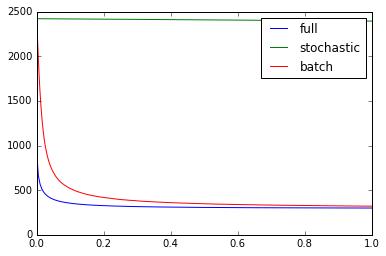

In [9]:
x1 = np.linspace(0, 1, len(LL))
plt.plot(x1, LL, label="full")
x2 = np.linspace(0, 1, len(LL_stochastic))
plt.plot(x2, LL_stochastic, label="stochastic")
x3 = np.linspace(0, 1, len(LL_batch))
plt.plot(x3, LL_batch, label="batch")
plt.legend()
plt.show()
# Full appears to converge faster than batch gradient descent, but it also ran slower

- Full always decreases smoothly, batch and stochastic do not